### ДЗ 3. Продвинутые сверточные архитектуры. Transfer Learning

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorboard
import tensorflow_datasets as tfds

In [19]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

KeyboardInterrupt: 

In [2]:
# Не знаю в чем тут дело - не получилось никаким способом выкачать датасет из tfds... 
# Раз 5 пробовал - закачка останавливается процентах на 7-10 и висит бесконечно.. 
# В итоге просто скачал его файлом из Кэггла..
# Правда теперь придется самому загружать картинки в виде датасета

In [11]:
import pathlib
import PIL.Image as Image

In [4]:
data_dir = pathlib.Path('dataset/images/')

In [7]:
# Сколько их там...
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

101000

In [10]:
# Посмотрим что нибудь
donuts = list(data_dir.glob('donuts/*'))
donuts[0]

PosixPath('dataset/images/donuts/3008531.jpg')

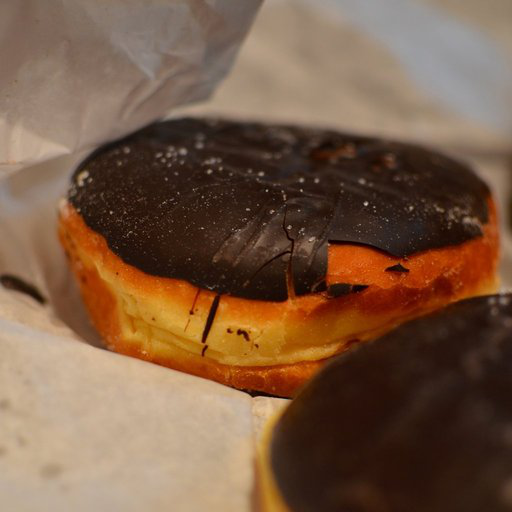

In [13]:
Image.open(donuts[0])

In [15]:
Image.open(donuts[0]).size

(512, 512)

In [16]:
BATCH_SIZE = 32
IMAGE_SIZE = 196

In [20]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


In [21]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [22]:
# Наши классы
class_names = train_ds.class_names
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

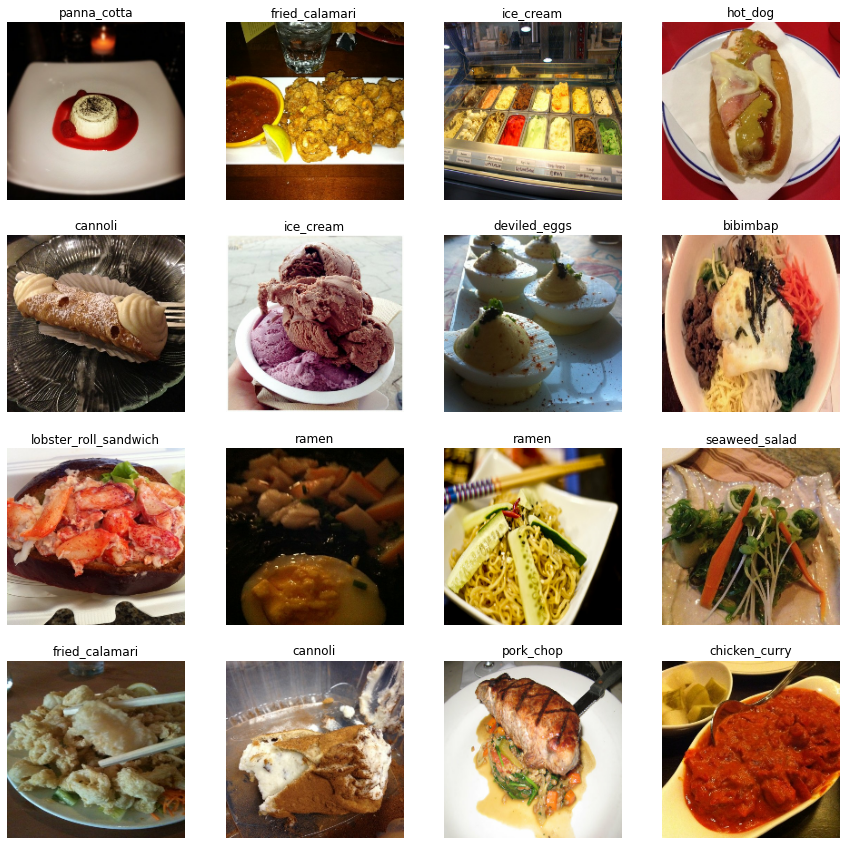

In [28]:
# Немного примеров
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [29]:
# Оптимизация кеширования
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [30]:
# Аугментация
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

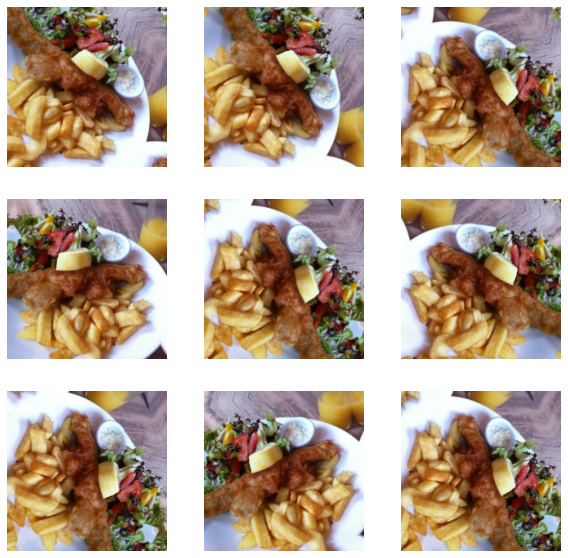

In [31]:
# Тест того, как работает аугментация
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [36]:
# Претрейненная сеть
base_net = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

219062272/219055592 [==============================] - 24s 0us/step


In [43]:
# Теперь соберем модель
inputs = tf.keras.Input(shape=(196, 196, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_net(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(101, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [44]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 196, 196, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 196, 196, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 196, 196, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 196, 196, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0   

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
# Попробуем!
history = model.fit(train_ds,
                    epochs=2,
                    validation_data=val_ds)

Epoch 1/2
2525/2525 [==============================] - 785s 311ms/step - loss: 1.0616 - accuracy: 0.7199 - val_loss: 1.0346 - val_accuracy: 0.7274
Epoch 2/2
2525/2525 [==============================] - 784s 310ms/step - loss: 0.8495 - accuracy: 0.7699 - val_loss: 0.9854 - val_accuracy: 0.7401


In [49]:
# Долговато до-учивать такую большую сеть на 101 тысяче картинок :))
# Ну - какая-то точность получилась - 74% - прогоним тест-инференс

In [50]:
test_batch = iter(val_ds).next()

In [51]:
predicts = np.argmax(model(test_batch[0]), axis=1)

In [52]:
predicts

array([39, 48, 69, 68, 31, 59, 37, 45, 24, 25, 69, 67, 80, 85, 59, 77, 78,
       44, 41, 75, 65, 22, 33, 97, 64, 31, 12, 86, 96, 51,  3, 86])

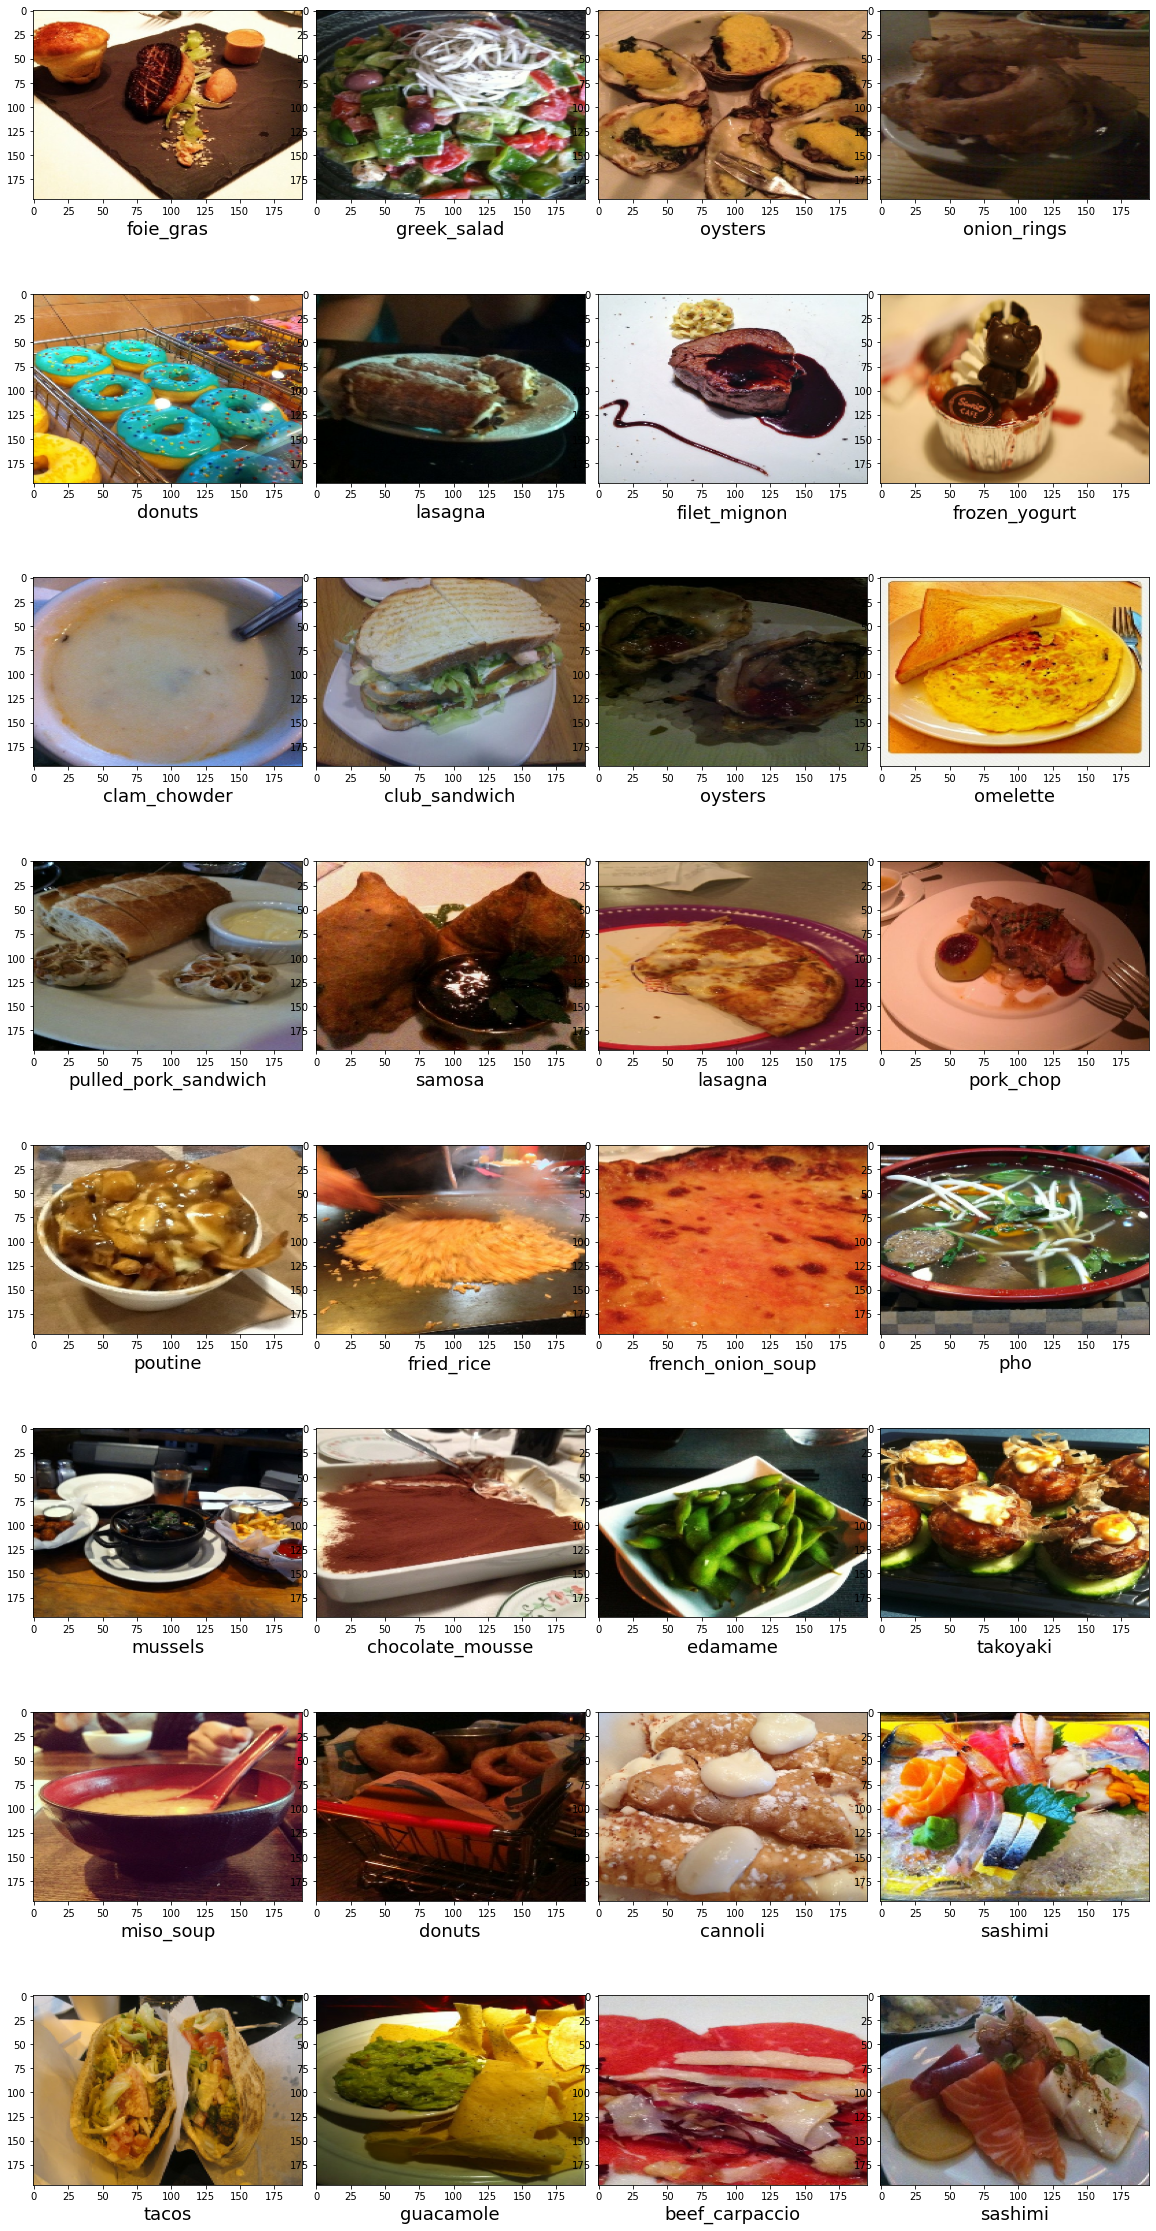

In [65]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(20,40))
for idx, image in enumerate(test_batch[0]):
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(image/255, cmap="gray", aspect="auto")
    axes[row, col].set_xlabel(class_names[predicts[idx]], fontsize=18)
plt.subplots_adjust(wspace=.05, hspace=.5)
plt.show()

In [67]:
# Что-то определяет. Еще бы самому знать все эти названия ))